In [1]:
%load_ext autoreload
%autoreload 2

from Eir import AgeStructuredSIRD, SIRD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use("../style.mplstyle")

In [3]:
days, dt = 31, 0.1

## SIRD 

In [11]:
S0=10_000_000
I0=2
R0=0
beta=1.5
gamma=.15
omega=0.01

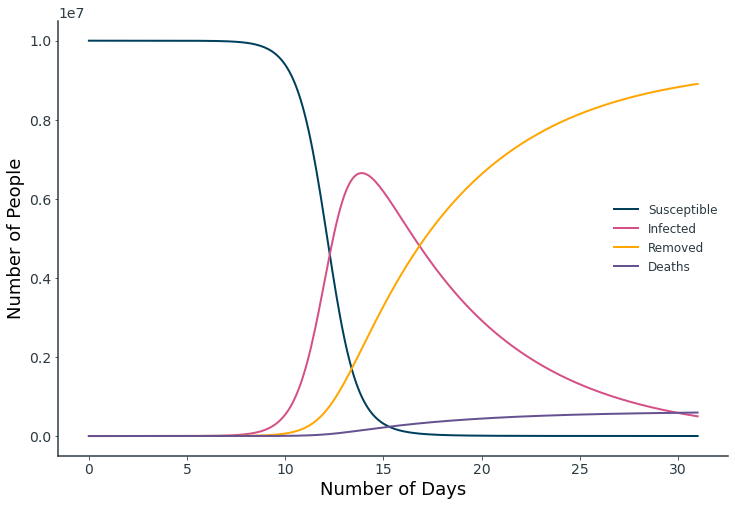

In [19]:
sim = SIRD(S0=S0, I0=I0, R0=R0, beta=beta, gamma=gamma, omega=omega)
df, fig = sim.run(days, dt)
fig;

In [20]:
df

,Days,Susceptible,Infected,Removed,Deaths
0,0.0,1.000000e+07,2.000000,0.000000e+00,0.000000
1,0.1,1.000000e+07,2.268000,3.000000e-02,0.002000
2,0.2,9.999999e+06,2.571912,6.402000e-02,0.004268
3,0.3,9.999999e+06,2.916548,1.025987e-01,0.006840
4,0.4,9.999999e+06,3.307365,1.463469e-01,0.009756
...,...,...,...,...,...
306,30.6,7.819149e+02,531218.871890,8.876251e+06,591750.075825
307,30.7,7.752925e+02,522725.992339,8.884219e+06,592281.294697
308,30.8,7.688308e+02,514368.838158,8.892060e+06,592804.020689
309,30.9,7.625251e+02,506145.242493,8.899776e+06,593318.389527


## AgeStructuredSIRD

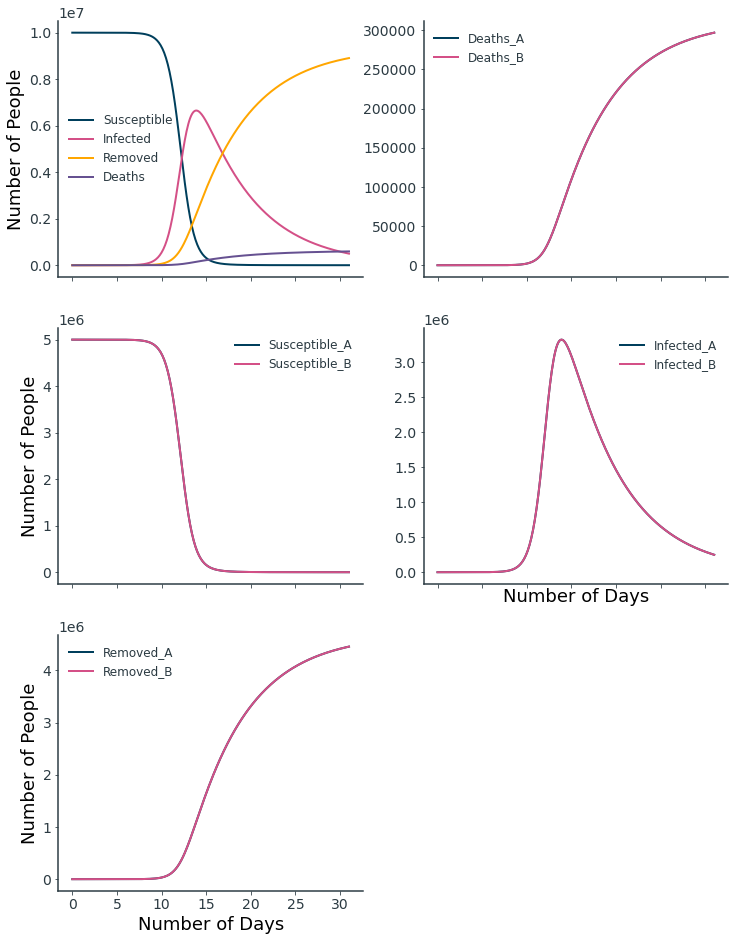

In [36]:
labels_as = ["A", "B"]
S0_as = [int(S0/2), int(S0/2)]
I0_as = [int(I0/2), int(I0/2)]
R0_as = [int(R0/2), int(R0/2)]
beta_as = np.array(
    [
        [beta/2, beta/2],
        [beta/2, beta/2],
    ]
)
gamma_as = [gamma, gamma]
omega_as = [omega, omega]

sim = AgeStructuredSIRD(labels_as, beta_as, gamma_as, omega_as, S0_as, I0_as, R0_as)
df_as, fig_as = sim.run(days, dt)
fig_as

In [38]:
# same results as base SIRD model
pd.testing.assert_frame_equal(df, df_as.iloc[:, :5], check_exact=False)

In [6]:
end_deaths = df.iloc[-1][["Deaths"] + [f"Deaths_{l}" for l in labels]].astype(int)
end_suscep = df.iloc[-1][["Susceptible"] + [f"Susceptible_{l}" for l in labels]].astype(int)
total = np.array([sum(N)] + list(N))
end_infect = total - end_suscep
fatality_rates = pd.Series(end_deaths.values / end_infect.values, index=end_deaths.index)
for g, f, d, i, t in zip(end_deaths.index, fatality_rates, end_deaths, end_infect, total):
    print(f"{g:12}: {f*100:.2f}% fatality rate - {d:7,} deaths - {i:10,}/{t:10,} infected")

Deaths      : 1.44% fatality rate - 952,730 deaths - 66,012,545/67,000,067 infected
Deaths_<20  : 0.10% fatality rate -  13,942 deaths - 13,975,050/14,000,014 infected
Deaths_20-40: 0.50% fatality rate -  88,829 deaths - 17,884,272/18,000,018 infected
Deaths_40-60: 0.99% fatality rate - 175,860 deaths - 17,795,099/18,000,018 infected
Deaths_60-80: 2.91% fatality rate - 346,818 deaths - 11,924,843/12,000,012 infected
Deaths_>80  : 7.38% fatality rate - 327,279 deaths -  4,433,282/ 5,000,005 infected


## AgeStructuredSIRVD

### Vaccinate Young First

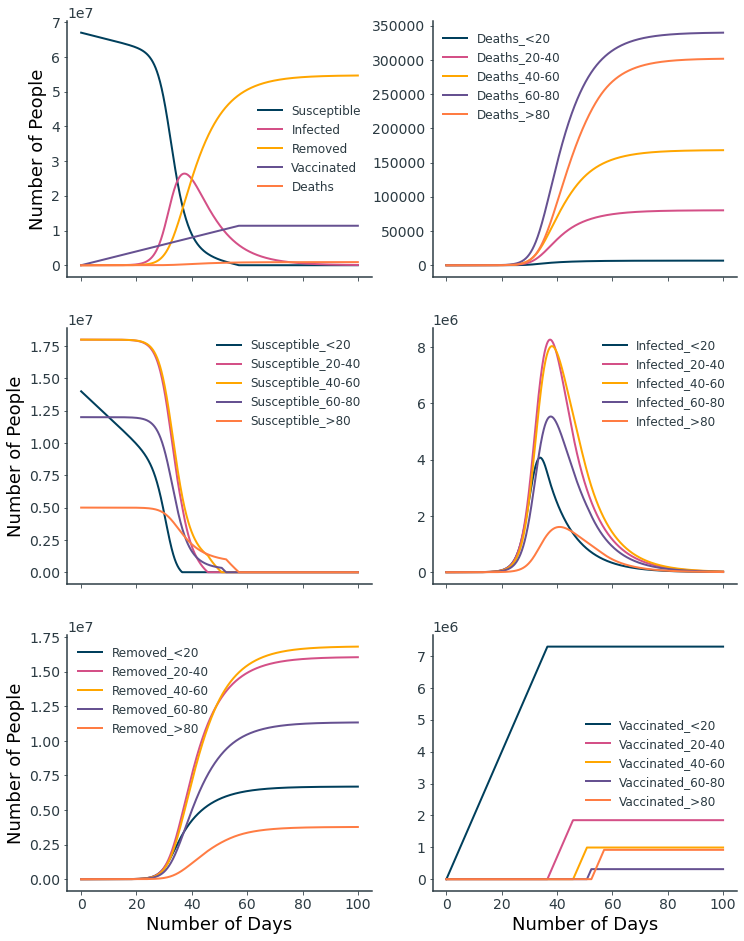

In [49]:
labels = ["<20", "20-40", "40-60", "60-80", ">80"]
S0 = [14000000, 18000000, 18000000, 12000000, 5000000]
I0 = [14, 18, 18, 12, 5]
R0 = [0, 0, 0, 0, 0]
V0, Vd = [0, 0, 0, 0, 0], 200_000
beta = np.array(
    [
        [0.25, 0.15625, 0.1, 0.0625, 0.00625],
        [0.15625, 0.1875, 0.1375, 0.0875, 0.0125],
        [0.1, 0.1375, 0.15625, 0.1125, 0.01875],
        [0.0625, 0.0875, 0.1125, 0.125, 0.025],
        [0.00625, 0.0125, 0.01875, 0.025, 0.03125],
    ]
)
gamma = [0.1, 0.1, 0.1, 0.1, 0.1]
omega = [0.0001, 0.0005, 0.001, 0.003, 0.008]
N = np.array(S0) + np.array(I0) + np.array(R0)

sim = AgeStructuredSIRVD(labels, beta, gamma, omega, Vd, S0, I0, R0, V0)
df, fig = sim.run(100, 0.1)
fig

In [50]:
end_deaths = df.iloc[-1][["Deaths"] + [f"Deaths_{l}" for l in labels]].astype(int)
end_suscep = df.iloc[-1][["Susceptible"] + [f"Susceptible_{l}" for l in labels]].astype(
    int
)
end_vaccin = df.iloc[-1][["Vaccinated"] + [f"Vaccinated_{l}" for l in labels]].astype(
    int
)
total = np.array([sum(N)] + list(N))
end_infect = total - end_suscep.values - end_vaccin.values
fatality_rates = pd.Series(end_deaths.values / end_infect, index=end_deaths.index)
for g, f, d, i, t, v in zip(
    end_deaths.index, fatality_rates, end_deaths, end_infect, total, end_vaccin
):
    print(
        f"{g:12}: {f*100:.2f}% fatality rate - {d:7,} deaths - {i:10,}/{t:10,} infected - vaccinated {v:10,}"
    )

Deaths      : 1.61% fatality rate - 896,806 deaths - 55,626,422/67,000,067 infected - vaccinated 11,373,645
Deaths_<20  : 0.10% fatality rate -   6,692 deaths -  6,704,599/14,000,014 infected - vaccinated  7,295,415
Deaths_20-40: 0.50% fatality rate -  80,243 deaths - 16,149,200/18,000,018 infected - vaccinated  1,850,818
Deaths_40-60: 0.99% fatality rate - 168,146 deaths - 17,007,101/18,000,018 infected - vaccinated    992,917
Deaths_60-80: 2.91% fatality rate - 339,928 deaths - 11,685,363/12,000,012 infected - vaccinated    314,649
Deaths_>80  : 7.40% fatality rate - 301,796 deaths -  4,080,161/ 5,000,005 infected - vaccinated    919,844


### Vaccinate Old First

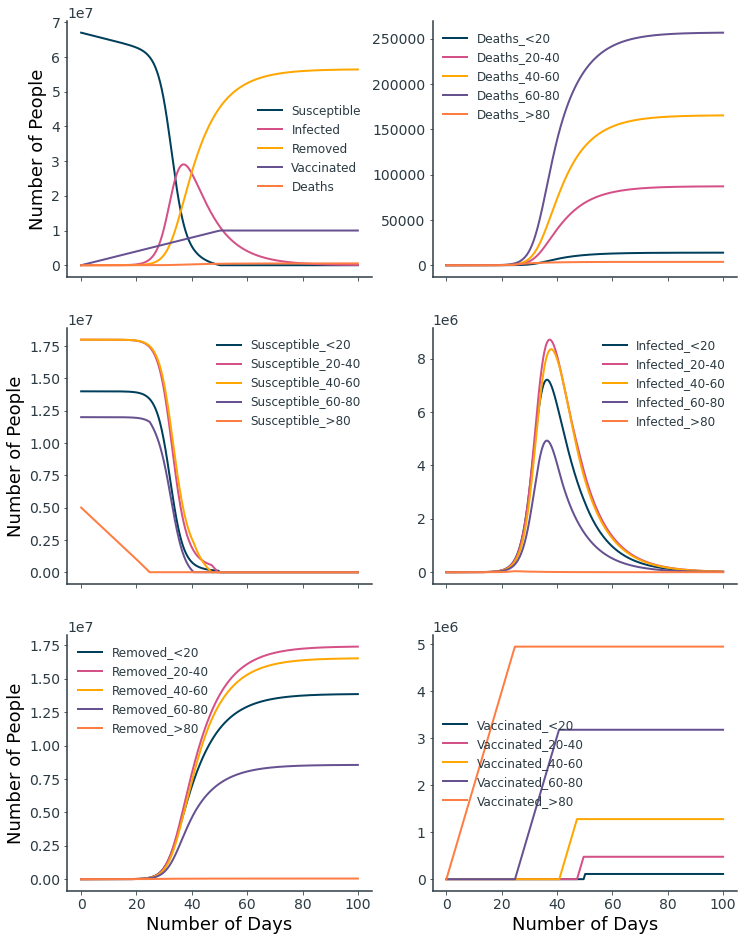

In [47]:
labels = ["<20", "20-40", "40-60", "60-80", ">80"]
S0 = [14000000, 18000000, 18000000, 12000000, 5000000]
I0 = [14, 18, 18, 12, 5]
R0 = [0, 0, 0, 0, 0]
V0, Vd = [0, 0, 0, 0, 0], 200_000
beta = np.array(
    [
        [0.25, 0.15625, 0.1, 0.0625, 0.00625],
        [0.15625, 0.1875, 0.1375, 0.0875, 0.0125],
        [0.1, 0.1375, 0.15625, 0.1125, 0.01875],
        [0.0625, 0.0875, 0.1125, 0.125, 0.025],
        [0.00625, 0.0125, 0.01875, 0.025, 0.03125],
    ]
)
gamma = [0.1, 0.1, 0.1, 0.1, 0.1]
omega = [0.0001, 0.0005, 0.001, 0.003, 0.008]
N = np.array(S0) + np.array(I0) + np.array(R0)

sim = AgeStructuredSIRVD(labels, beta, gamma, omega, Vd, S0, I0, R0, V0)
df, fig = sim.run(100, 0.1, reverse=True)
fig

In [48]:
end_deaths = df.iloc[-1][["Deaths"] + [f"Deaths_{l}" for l in labels]].astype(int)
end_suscep = df.iloc[-1][["Susceptible"] + [f"Susceptible_{l}" for l in labels]].astype(
    int
)
end_vaccin = df.iloc[-1][["Vaccinated"] + [f"Vaccinated_{l}" for l in labels]].astype(
    int
)
total = np.array([sum(N)] + list(N))
end_infect = total - end_suscep.values - end_vaccin.values
fatality_rates = pd.Series(end_deaths.values / end_infect, index=end_deaths.index)
for g, f, d, i, t, v in zip(
    end_deaths.index, fatality_rates, end_deaths, end_infect, total, end_vaccin
):
    print(
        f"{g:12}: {f*100:.2f}% fatality rate - {d:7,} deaths - {i:10,}/{t:10,} infected - vaccinated {v:10,}"
    )

Deaths      : 0.92% fatality rate - 526,613 deaths - 57,003,954/67,000,067 infected - vaccinated  9,996,113
Deaths_<20  : 0.10% fatality rate -  13,858 deaths - 13,889,334/14,000,014 infected - vaccinated    110,680
Deaths_20-40: 0.50% fatality rate -  87,063 deaths - 17,523,365/18,000,018 infected - vaccinated    476,653
Deaths_40-60: 0.99% fatality rate - 165,344 deaths - 16,721,553/18,000,018 infected - vaccinated  1,278,465
Deaths_60-80: 2.91% fatality rate - 256,648 deaths -  8,819,755/12,000,012 infected - vaccinated  3,180,257
Deaths_>80  : 7.41% fatality rate -   3,699 deaths -     49,949/ 5,000,005 infected - vaccinated  4,950,056


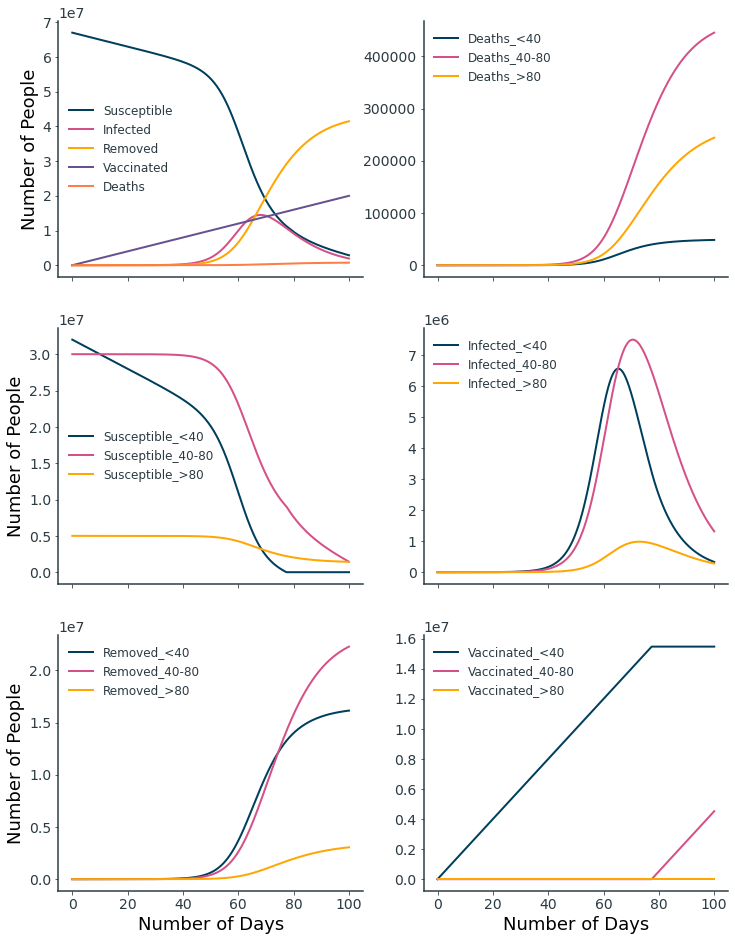

In [53]:
labels = ["<40", "40-80", ">80"]
S0 = [32_000_000, 30_000_000, 5_000_000]
I0 = [32, 30, 5]
R0 = [0, 0, 0]
V0, Vd = [0, 0, 0], 200_000
beta = np.array(
    [
        [0.25, 0.1, 0.00625],
        [0.1, 0.15625, 0.01875],
        [0.00625, 0.01875, 0.03125],
    ]
)
gamma = [0.1, 0.1, 0.1]
omega = [0.0003, 0.002, 0.008]
N = np.array(S0) + np.array(I0) + np.array(R0)

sim = AgeStructuredSIRVD(labels, beta, gamma, omega, Vd, S0, I0, R0, V0)
df, fig = sim.run(100, 0.1)
fig

In [54]:
end_deaths = df.iloc[-1][["Deaths"] + [f"Deaths_{l}" for l in labels]].astype(int)
end_suscep = df.iloc[-1][["Susceptible"] + [f"Susceptible_{l}" for l in labels]].astype(
    int
)
end_vaccin = df.iloc[-1][["Vaccinated"] + [f"Vaccinated_{l}" for l in labels]].astype(
    int
)
total = np.array([sum(N)] + list(N))
end_infect = total - end_suscep.values - end_vaccin.values
fatality_rates = pd.Series(end_deaths.values / end_infect, index=end_deaths.index)
for g, f, d, i, t, v in zip(
    end_deaths.index, fatality_rates, end_deaths, end_infect, total, end_vaccin
):
    print(
        f"{g:12}: {f*100:.2f}% fatality rate - {d:7,} deaths - {i:10,}/{t:10,} infected - vaccinated {v:10,}"
    )

Deaths      : 1.67% fatality rate - 738,213 deaths - 44,142,346/67,000,067 infected - vaccinated 19,993,591
Deaths_<40  : 0.29% fatality rate -  48,441 deaths - 16,526,441/32,000,032 infected - vaccinated 15,473,591
Deaths_40-80: 1.85% fatality rate - 445,487 deaths - 24,039,028/30,000,030 infected - vaccinated  4,520,000
Deaths_>80  : 6.83% fatality rate - 244,284 deaths -  3,576,877/ 5,000,005 infected - vaccinated          0


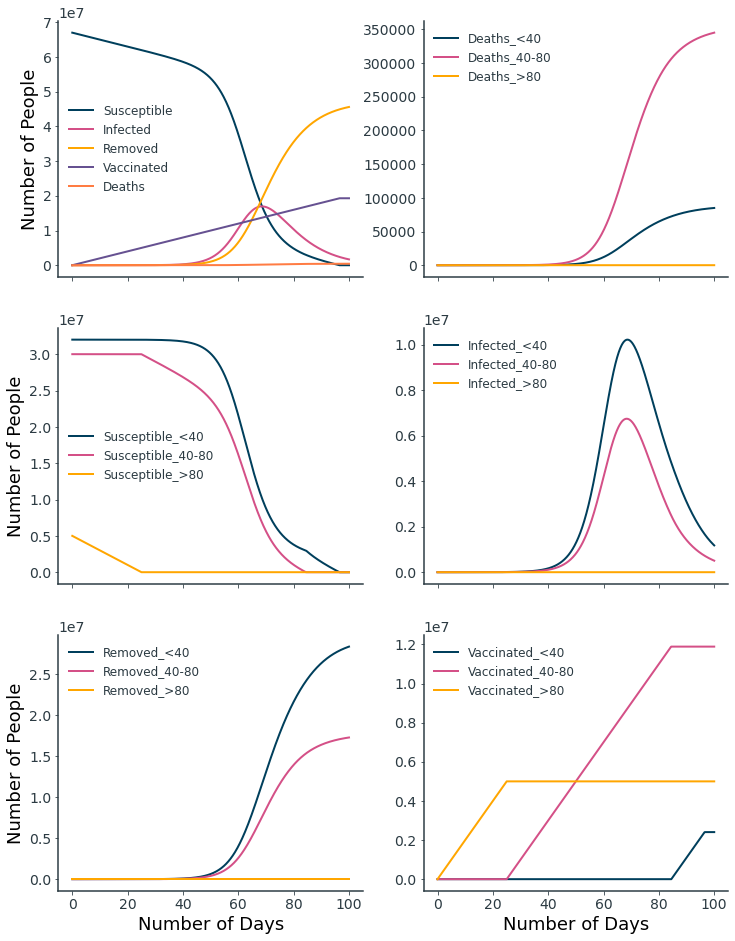

In [55]:
labels = ["<40", "40-80", ">80"]
S0 = [32_000_000, 30_000_000, 5_000_000]
I0 = [32, 30, 5]
R0 = [0, 0, 0]
V0, Vd = [0, 0, 0], 200_000
beta = np.array(
    [
        [0.25, 0.1, 0.00625],
        [0.1, 0.15625, 0.01875],
        [0.00625, 0.01875, 0.03125],
    ]
)
gamma = [0.1, 0.1, 0.1]
omega = [0.0003, 0.002, 0.008]
N = np.array(S0) + np.array(I0) + np.array(R0)

sim = AgeStructuredSIRVD(labels, beta, gamma, omega, Vd, S0, I0, R0, V0)
df, fig = sim.run(100, 0.1, reverse=True)
fig

In [56]:
end_deaths = df.iloc[-1][["Deaths"] + [f"Deaths_{l}" for l in labels]].astype(int)
end_suscep = df.iloc[-1][["Susceptible"] + [f"Susceptible_{l}" for l in labels]].astype(
    int
)
end_vaccin = df.iloc[-1][["Vaccinated"] + [f"Vaccinated_{l}" for l in labels]].astype(
    int
)
total = np.array([sum(N)] + list(N))
end_infect = total - end_suscep.values - end_vaccin.values
fatality_rates = pd.Series(end_deaths.values / end_infect, index=end_deaths.index)
for g, f, d, i, t, v in zip(
    end_deaths.index, fatality_rates, end_deaths, end_infect, total, end_vaccin
):
    print(
        f"{g:12}: {f*100:.2f}% fatality rate - {d:7,} deaths - {i:10,}/{t:10,} infected - vaccinated {v:10,}"
    )

Deaths      : 0.90% fatality rate - 430,267 deaths - 47,707,037/67,000,067 infected - vaccinated 19,293,030
Deaths_<40  : 0.29% fatality rate -  84,995 deaths - 29,593,924/32,000,032 infected - vaccinated  2,406,108
Deaths_40-80: 1.91% fatality rate - 345,222 deaths - 18,112,447/30,000,030 infected - vaccinated 11,887,583
Deaths_>80  : 7.35% fatality rate -      49 deaths -        667/ 5,000,005 infected - vaccinated  4,999,338
